# Adapted from Text generation with an RNN

This tutorial demonstrates how to generate text using a character-based RNN. We will work with a dataset of Shakespeare's writing from Andrej Karpathy's [The Unreasonable Effectiveness of Recurrent Neural Networks](http://karpathy.github.io/2015/05/21/rnn-effectiveness/). Given a sequence of characters from this data ("Shakespear"), train a model to predict the next character in the sequence ("e"). Longer sequences of text can be generated by calling the model repeatedly.

Note: Enable GPU acceleration to execute this notebook faster. In Colab: *Runtime > Change runtime type > Hardware acclerator > GPU*. If running locally make sure TensorFlow version >= 1.11.

This tutorial includes runnable code implemented using [tf.keras](https://www.tensorflow.org/programmers_guide/keras) and [eager execution](https://www.tensorflow.org/programmers_guide/eager). The following is sample output when the model in this tutorial trained for 30 epochs, and started with the string "Q":



While some of the sentences are grammatical, most do not make sense. The model has not learned the meaning of words, but consider:

* The model is character-based. When training started, the model did not know how to spell an English word, or that words were even a unit of text.

* The structure of the output resembles a play—blocks of text generally begin with a speaker name, in all capital letters similar to the dataset.

* As demonstrated below, the model is trained on small batches of text (100 characters each), and is still able to generate a longer sequence of text with coherent structure.

## Setup

### Import TensorFlow and other libraries

In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals

try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass
import tensorflow as tf

import numpy as np
import re
import os
import time

tf.enable_eager_execution()

### Download the dataset

Change the following line to run this code on your own data.

In [5]:
path_to_file = tf.keras.utils.get_file('sabina.txt', 'https://raw.githubusercontent.com/podemosaprender/data-texto/master/letras.txt')
print(path_to_file)

C:\Users\usr11\.keras\datasets\sabina.txt


### Read the data

First, look in the text:

In [6]:
# Read, then decode for py2 compat.
text = open(path_to_file, 'rb').read().decode(encoding='utf-8')
text = text.lower()
text = re.sub(r"#[^\n]*\n","",text ) # quito los titulos
text = re.sub(r"\t"," ",text) # algunas palabras estaban separadas con tabs
text = re.sub(r"[^a-záéíóúñ \n]","",text) # solo me quedo con letras y enter
text = re.sub(r"  +"," ",text) # muchos espacios a uno solo
text = re.sub(r"\n\n+","\n",text) # muchos enter a uno solo
# length of text is the number of characters in it
print ('Length of text: {} characters'.format(len(text)))

Length of text: 205930 characters


In [ ]:
# Take a look at the first 250 characters in text
print(text[:250])

In [7]:
# The unique characters in the file
vocab = sorted(set(text))
print ('{} unique characters'.format(len(vocab)))

34 unique characters


## Process the text

### Vectorize the text

Before training, we need to map strings to a numerical representation. Create two lookup tables: one mapping characters to numbers, and another for numbers to characters.

In [8]:
# Creating a mapping from unique characters to indices
char2idx = {u:i for i, u in enumerate(vocab)}
idx2char = np.array(vocab)

text_as_int = np.array([char2idx[c] for c in text])

Now we have an integer representation for each character. Notice that we mapped the character as indexes from 0 to `len(unique)`.

In [ ]:
print('{')
for char,_ in zip(char2idx, range(20)):
    print('  {:4s}: {:3d},'.format(repr(char), char2idx[char]))
print('  ...\n}')

In [ ]:
# Show how the first 13 characters from the text are mapped to integers
print ('{} ---- characters mapped to int ---- > {}'.format(repr(text[:13]), text_as_int[:13]))

### The prediction task

Given a character, or a sequence of characters, what is the most probable next character? This is the task we're training the model to perform. The input to the model will be a sequence of characters, and we train the model to predict the output—the following character at each time step.

Since RNNs maintain an internal state that depends on the previously seen elements, given all the characters computed until this moment, what is the next character?


### Create training examples and targets

Next divide the text into example sequences. Each input sequence will contain `seq_length` characters from the text.

For each input sequence, the corresponding targets contain the same length of text, except shifted one character to the right.

So break the text into chunks of `seq_length+1`. For example, say `seq_length` is 4 and our text is "Hello". The input sequence would be "Hell", and the target sequence "ello".

To do this first use the `tf.data.Dataset.from_tensor_slices` function to convert the text vector into a stream of character indices.

In [ ]:
# The maximum length sentence we want for a single input in characters
seq_length = 100
examples_per_epoch = len(text)//(seq_length+1)

# Create training examples / targets
char_dataset = tf.data.Dataset.from_tensor_slices(text_as_int)

for i in char_dataset.take(5):
  print(idx2char[i.numpy()])

The `batch` method lets us easily convert these individual characters to sequences of the desired size.

In [ ]:
sequences = char_dataset.batch(seq_length+1, drop_remainder=True)

for item in sequences.take(5):
  print(repr(''.join(idx2char[item.numpy()])))

For each sequence, duplicate and shift it to form the input and target text by using the `map` method to apply a simple function to each batch:

In [ ]:
def split_input_target(chunk):
    input_text = chunk[:-1]
    target_text = chunk[1:]
    return input_text, target_text

dataset = sequences.map(split_input_target)

Print the first examples input and target values:

In [ ]:
for input_example, target_example in  dataset.take(1):
  print ('Input data: ', repr(''.join(idx2char[input_example.numpy()])))
  print ('Target data:', repr(''.join(idx2char[target_example.numpy()])))

Each index of these vectors are processed as one time step. For the input at time step 0, the model receives the index for "F" and trys to predict the index for "i" as the next character. At the next timestep, it does the same thing but the `RNN` considers the previous step context in addition to the current input character.

In [ ]:
for i, (input_idx, target_idx) in enumerate(zip(input_example[:5], target_example[:5])):
    print("Step {:4d}".format(i))
    print("  input: {} ({:s})".format(input_idx, repr(idx2char[input_idx])))
    print("  expected output: {} ({:s})".format(target_idx, repr(idx2char[target_idx])))

### Create training batches

We used `tf.data` to split the text into manageable sequences. But before feeding this data into the model, we need to shuffle the data and pack it into batches.

In [ ]:
# Batch size
BATCH_SIZE = 64

# Buffer size to shuffle the dataset
# (TF data is designed to work with possibly infinite sequences,
# so it doesn't attempt to shuffle the entire sequence in memory. Instead,
# it maintains a buffer in which it shuffles elements).
BUFFER_SIZE = 10000

dataset = dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE, drop_remainder=True)

dataset

## Build The Model

Use `tf.keras.Sequential` to define the model. For this simple example three layers are used to define our model:

* `tf.keras.layers.Embedding`: The input layer. A trainable lookup table that will map the numbers of each character to a vector with `embedding_dim` dimensions;
* `tf.keras.layers.GRU`: A type of RNN with size `units=rnn_units` (You can also use a LSTM layer here.)
* `tf.keras.layers.Dense`: The output layer, with `vocab_size` outputs.

In [9]:
# Length of the vocabulary in chars
vocab_size = len(vocab)

# The embedding dimension
embedding_dim = 256

# Number of RNN units
rnn_units = 512

In [11]:
def build_model(vocab_size, embedding_dim, rnn_units, batch_size):
  model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim,
                              batch_input_shape=[batch_size, None]),
    tf.keras.layers.GRU(rnn_units,
                        return_sequences=True,
                        stateful=True,
                        recurrent_initializer='glorot_uniform'),
    tf.keras.layers.Dense(vocab_size)
  ])
  return model

In [ ]:
model = build_model(
  vocab_size = len(vocab),
  embedding_dim=embedding_dim,
  rnn_units=rnn_units,
  batch_size=BATCH_SIZE)

For each character the model looks up the embedding, runs the GRU one timestep with the embedding as input, and applies the dense layer to generate logits predicting the log-likelihood of the next character:

![A drawing of the data passing through the model](images/text_generation_training.png)

## Try the model

Now run the model to see that it behaves as expected.

First check the shape of the output:

In [ ]:
for input_example_batch, target_example_batch in dataset.take(1):
  example_batch_predictions = model(input_example_batch)
  print(example_batch_predictions.shape, "# (batch_size, sequence_length, vocab_size)")

In the above example the sequence length of the input is `100` but the model can be run on inputs of any length:

In [ ]:
model.summary()

To get actual predictions from the model we need to sample from the output distribution, to get actual character indices. This distribution is defined by the logits over the character vocabulary.

Note: It is important to _sample_ from this distribution as taking the _argmax_ of the distribution can easily get the model stuck in a loop.

Try it for the first example in the batch:

In [ ]:
sampled_indices = tf.random.categorical(example_batch_predictions[0], num_samples=1)
sampled_indices = tf.squeeze(sampled_indices,axis=-1).numpy()

This gives us, at each timestep, a prediction of the next character index:

In [ ]:
sampled_indices

Decode these to see the text predicted by this untrained model:

In [ ]:
print("Input: \n", repr("".join(idx2char[input_example_batch[0]])))
print()
print("Next Char Predictions: \n", repr("".join(idx2char[sampled_indices ])))

## Train the model

At this point the problem can be treated as a standard classification problem. Given the previous RNN state, and the input this time step, predict the class of the next character.

### Attach an optimizer, and a loss function

The standard `tf.keras.losses.sparse_categorical_crossentropy` loss function works in this case because it is applied across the last dimension of the predictions.

Because our model returns logits, we need to set the `from_logits` flag.


In [ ]:
def loss(labels, logits):
  return tf.keras.losses.sparse_categorical_crossentropy(labels, logits, from_logits=True)

example_batch_loss  = loss(target_example_batch, example_batch_predictions)
print("Prediction shape: ", example_batch_predictions.shape, " # (batch_size, sequence_length, vocab_size)")
print("scalar_loss:      ", example_batch_loss.numpy().mean())

Configure the training procedure using the `tf.keras.Model.compile` method. We'll use `tf.keras.optimizers.Adam` with default arguments and the loss function.

In [ ]:
model.compile(optimizer='adam', loss=loss)

### Configure checkpoints

Use a `tf.keras.callbacks.ModelCheckpoint` to ensure that checkpoints are saved during training:

In [2]:
# Directory where the checkpoints will be saved
checkpoint_dir = './training_checkpoints'
# Name of the checkpoint files
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt_{epoch}")

checkpoint_callback=tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_prefix,
    save_weights_only=True)

### Execute the training

To keep training time reasonable, use 10 epochs to train the model. In Colab, set the runtime to GPU for faster training.

In [ ]:
EPOCHS=30

In [ ]:
history = model.fit(dataset, epochs=EPOCHS, callbacks=[checkpoint_callback])

## Generate text

### Restore the latest checkpoint

To keep this prediction step simple, use a batch size of 1.

Because of the way the RNN state is passed from timestep to timestep, the model only accepts a fixed batch size once built.

To run the model with a different `batch_size`, we need to rebuild the model and restore the weights from the checkpoint.


In [3]:
tf.train.latest_checkpoint(checkpoint_dir)

'./training_checkpoints\\ckpt_30'

In [ ]:
os.getcwd()

In [12]:
model = build_model(vocab_size, embedding_dim, rnn_units, batch_size=1)

model.load_weights(tf.train.latest_checkpoint(checkpoint_dir))

model.build(tf.TensorShape([1, None]))

In [13]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (1, None, 256)            8704      
_________________________________________________________________
gru (GRU)                    (1, None, 512)            1181184   
_________________________________________________________________
dense (Dense)                (1, None, 34)             17442     
Total params: 1,207,330
Trainable params: 1,207,330
Non-trainable params: 0
_________________________________________________________________


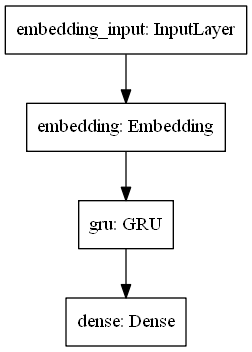

In [14]:
tf.keras.utils.plot_model(
    model
)

### The prediction loop

The following code block generates the text:

* It Starts by choosing a start string, initializing the RNN state and setting the number of characters to generate.

* Get the prediction distribution of the next character using the start string and the RNN state.

* Then, use a categorical distribution to calculate the index of the predicted character. Use this predicted character as our next input to the model.

* The RNN state returned by the model is fed back into the model so that it now has more context, instead than only one word. After predicting the next word, the modified RNN states are again fed back into the model, which is how it learns as it gets more context from the previously predicted words.


![To generate text the model's output is fed back to the input](images/text_generation_sampling.png)

Looking at the generated text, you'll see the model knows when to capitalize, make paragraphs and imitates a Shakespeare-like writing vocabulary. With the small number of training epochs, it has not yet learned to form coherent sentences.

In [54]:
def generate_text(model, start_string):
  # Evaluation step (generating text using the learned model)

  # Number of characters to generate
  num_generate = 400

  # Converting our start string to numbers (vectorizing)
  input_eval = [char2idx[s] for s in start_string]
  input_eval = tf.expand_dims(input_eval, 0)
  #print(input_eval)

  # Empty string to store our results
  text_generated = []

  # Low temperatures results in more predictable text.
  # Higher temperatures results in more surprising text.
  # Experiment to find the best setting.
  temperature = .1

  # Here batch size == 1
  model.reset_states()
  for i in range(num_generate):
      predictions = model(input_eval)
      # remove the batch dimension
      predictions = tf.squeeze(predictions, 0)
      #print(predictions)
      # using a categorical distribution to predict the word returned by the model
      predictions = predictions / temperature
      predicted_id = tf.random.categorical(predictions, num_samples=1)[-1,0].numpy()

      # We pass the predicted word as the next input to the model
      # along with the previous hidden state
      input_eval = tf.expand_dims([predicted_id], 0)

      text_generated.append(idx2char[predicted_id])

  return (start_string + ''.join(text_generated))

In [55]:
print(generate_text(model, start_string=u"dice mi red neuronal imitando a sabina que "))

dice mi red neuronal imitando a sabina que en la prensa del amanecer
no hay quien si llegar a fin antento
que es mi carma de la lluvia sobrenan los despojos
del mar de la mano
que el lune al corazón con la noche
contra el mal de amor
si yo fuera mujer si me de lo que después te quiero que el mi dio perdido
el mes de abril
se me dije que estaba más de lo que perdí
ella esta canción de las noches perdidas
que en la primera que llegar lo que 


The easiest thing you can do to improve the results it to train it for longer (try `EPOCHS=30`).

You can also experiment with a different start string, or try adding another RNN layer to improve the model's accuracy, or adjusting the temperature parameter to generate more or less random predictions.

## Advanced: Customized Training

The above training procedure is simple, but does not give you much control.

So now that you've seen how to run the model manually let's unpack the training loop, and implement it ourselves. This gives a starting point if, for example, to implement _curriculum learning_ to help stabilize the model's open-loop output.

We will use `tf.GradientTape` to track the gradients. You can learn more about this approach by reading the [eager execution guide](https://www.tensorflow.org/guide/eager).

The procedure works as follows:

* First, initialize the RNN state. We do this by calling the `tf.keras.Model.reset_states` method.

* Next, iterate over the dataset (batch by batch) and calculate the *predictions* associated with each.

* Open a `tf.GradientTape`, and calculate the predictions and loss in that context.

* Calculate the gradients of the loss with respect to the model variables using the `tf.GradientTape.grads` method.

* Finally, take a step downwards by using the optimizer's `tf.train.Optimizer.apply_gradients` method.



In [ ]:
model = build_model(
  vocab_size = len(vocab),
  embedding_dim=embedding_dim,
  rnn_units=rnn_units,
  batch_size=BATCH_SIZE)

In [ ]:
optimizer = tf.keras.optimizers.Adam()

In [ ]:
@tf.function
def train_step(inp, target):
  with tf.GradientTape() as tape:
    predictions = model(inp)
    loss = tf.reduce_mean(
        tf.keras.losses.sparse_categorical_crossentropy(
            target, predictions, from_logits=True))
  grads = tape.gradient(loss, model.trainable_variables)
  optimizer.apply_gradients(zip(grads, model.trainable_variables))

  return loss

In [ ]:
# Training step
EPOCHS = 30

for epoch in range(EPOCHS):
  start = time.time()

  # initializing the hidden state at the start of every epoch
  # initally hidden is None
  hidden = model.reset_states()

  for (batch_n, (inp, target)) in enumerate(dataset):
    loss = train_step(inp, target)

    if batch_n % 100 == 0:
      template = 'Epoch {} Batch {} Loss {}'
      print(template.format(epoch+1, batch_n, loss))

  # saving (checkpoint) the model every 5 epochs
  if (epoch + 1) % 5 == 0:
    model.save_weights(checkpoint_prefix.format(epoch=epoch))

  print ('Epoch {} Loss {:.4f}'.format(epoch+1, loss))
  print ('Time taken for 1 epoch {} sec\n'.format(time.time() - start))

model.save_weights(checkpoint_prefix.format(epoch=epoch))